In [1]:
import glob

import gseapy as gp
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
from biomart import BiomartServer
from scripts import aesthetics
from sklearn import decomposition, preprocessing

from scripts import helper

aesthetics.activate_paper_rcParams()

pd.set_option("display.max_columns", 1000)

%load_ext autoreload
%autoreload 2

# Neuroblastoma Preprocess RNA

In this notebook, we'll process the RNA for the neuroblastoma and take a look at some QC metrics.

We have two datasets for this--data from Gabriella Miller Kids First (GMKF) as well as (later) St. Jude's data. This notebook will process both.

# How we're handling this data

Unfortunately, the GMKF and St Jude data was generated differently--GMKF uses RSEM (far more standard, in my opinion), while StJude uses HTSeq (with some odd changes to default settings). HTSeq does not calculate TPMs, only counts. We need to align these data.

To align these data, we could do any of the following:

1. Use normalized counts (i.e. CPM), which ignores gene length. This is likely fine as we don't actually care about comparing genes, just the same gene across different samples.
2. Generate TPMs from HTSeq data. This approach might be somewhat preferable since I just like using TPMs.
3. Do the above, but then renormalize TPMs to just the genes that are included. I suppose technically there are good justifications to doing this.

My initial work suggests that these three approaches do actually yield different (if slightly) results. Whenever this happens, I tend to just generate all three and make a decision downstream.

# Load our samples and reference gene lists

In [2]:
# define metadata
metadata_path = "gs://vanallen-pedsv-analysis/sample_info/PedSV.v2.5.3.cohort_metadata.w_control_assignments.tsv.gz"
samples_path = "gs://vanallen-pedsv-analysis/sample_info/PedSV.v2.5.3.final_analysis_cohort.samples.list"

In [3]:
# list of genes that are annotated - drop ensembl IDs
gene_ref = pd.read_csv(
    "ref/gencode_hg38_protein_coding_genes_for_annotation_7_31_23.txt"
)
gene_ref = gene_ref[~gene_ref["value"].str.startswith("ENSG00")]
gene_ref = gene_ref["value"].tolist()

Load metadata and SVs

In [4]:
metadata = pd.read_csv(
    metadata_path,
    sep="\t",
)

# add a sex label to metadata
metadata["sex"] = (metadata["chrX_CopyNumber"].round() < 2).astype(int)

# Read in our RNA data for GMKF and St Jude

We're just going to do this all together for consistency, though we'll have to reorient a bit.

## GMKF

Load our TPMs. We'll briefly take a look at the manifest file first.

In [5]:
gmkf_manifest = pd.read_csv(
    "data/CWAS data for Jett/GMKF_Neuroblastoma_Germline_Structural_Variant_Analysis_RSEM_expression_files/GMKF_neuroblastoma_transcriptomic_data_manifest_rsem_gene_files_2_22_22.txt",
    sep="\t",
)
gmkf_manifest = gmkf_manifest.dropna(subset=gmkf_manifest.columns, how="all")
gmkf_manifest.head(2)

,id,name,file_name_simplified,size,project,ethnicity,gender,race,vital_status,sample_id,sample_type,platform,age_at_diagnosis,tumor_location,aliquot_id,library_id,histology,composition,reference_genome,species,case_id,data_type,investigation,experimental_strategy
0,62140522c087b02cb6535584,4452cf2b-df37-439b-92d0-7e3853c50eee.rsem.gene...,4452cf2b-df37-439b-92d0-7e3853c50eee,2503209.0,rgillani/gmkf-neuroblastoma-transcriptomic-data,Not Hispanic or Latino,Female,Reported Unknown,Alive,BS_5W25GMQ1,Tumor,Illumina,1295.0,Reported Unknown,575765.0,GMKF-30-PATMDE03-01B-99R,"Ganglioneuroblastoma, intermixed",Solid Tissue,GRCh38,Homo sapiens,PT_4A1B95TK,Gene Expression,Discovering the Genetic Basis of Human Neurobl...,RNA-Seq
1,62140522c087b02cb6535578,7e31540e-112f-439a-9562-ad760bb6d5c5.rsem.gene...,7e31540e-112f-439a-9562-ad760bb6d5c5,2488632.0,rgillani/gmkf-neuroblastoma-transcriptomic-data,Not Hispanic or Latino,Male,White,Alive,BS_5Y7PNW71,Tumor,Illumina,1712.0,Reported Unknown,575872.0,GMKF-30-PAVKZC03-01A-01R,"Ganglioneuroblastoma, nodular",Solid Tissue,GRCh38,Homo sapiens,PT_GSWXPFPQ,Gene Expression,Discovering the Genetic Basis of Human Neurobl...,RNA-Seq


In [6]:
gmkf_manifest.shape

(209, 24)

Not very useful at all, but it does give us a way to map file names to sample names.

In [7]:
file_to_sample = dict(zip(gmkf_manifest["name"], gmkf_manifest["case_id"]))

In [8]:
gmkf_tpms = []
gmkf_counts = []
for file in glob.glob(
    "data/CWAS data for Jett/GMKF_Neuroblastoma_Germline_Structural_Variant_Analysis_RSEM_expression_files/*.rsem.genes.tsv"
):
    file_name = file.split("/")[-1][:-3] + "results.gz"

    sample = file_to_sample[file_name]

    data = pd.read_csv(file, sep="\t")
    data["sample"] = sample
    gmkf_tpms.append(data[["sample", "gene_id", "TPM"]])
    gmkf_counts.append(data[["sample", "gene_id", "expected_count"]])

gmkf_tpms = pd.concat(gmkf_tpms)
gmkf_tpms = gmkf_tpms.pivot(
    index="gene_id", columns="sample", values="TPM"
).reset_index()

gmkf_counts = pd.concat(gmkf_counts)
gmkf_counts = gmkf_counts.pivot(
    index="gene_id", columns="sample", values="expected_count"
).reset_index()

for d in [gmkf_tpms, gmkf_counts]:
    d.insert(1, "ENSEMBL_ID", d["gene_id"].apply(lambda x: x.split(".")[0]))
    d.insert(2, "gene_symbol", d["gene_id"].apply(lambda x: x.split("_")[-1]))

In [9]:
gmkf_tpms.to_csv("data/gmkf_neuroblastoma_tpms.csv", index=False)
gmkf_counts.to_csv("data/gmkf_neuroblastoma_counts.csv", index=False)

In [10]:
gmkf_tpms

sample,gene_id,ENSEMBL_ID,gene_symbol,PT_02SNWVRF,PT_0XAWD5CE,PT_10KTTTPD,PT_11XN6CG5,PT_1396H6SD,PT_1EQHANKW,PT_1MWZEHCT,PT_1NDSW1JX,PT_1RH3DTPB,PT_1X6CJ589,PT_1X9YQF9W,PT_1YAJEAMJ,PT_21PJ8R0Z,PT_22BQQFYM,PT_26E4RFYV,PT_2AZNEYG9,PT_2DX56CE0,PT_2FB9C15K,PT_2G290D0G,PT_2HCWZNTR,PT_2JZNQGTR,PT_2M970JK9,PT_2QB9MP9J,PT_2RZN4HR2,PT_2Y7Q85BM,PT_2YBKT6RW,PT_3VNMNFT6,PT_3WF5J3PZ,PT_3YW2V4JK,PT_49FZV0HC,PT_4A1B95TK,PT_4FTZAAC4,PT_4W8PD8TR,PT_4WVGKQRX,PT_4Y3P2N1P,PT_53M7K3JE,PT_56ZM694R,PT_581CW7RN,PT_58J0PB4V,PT_5CPS8GNT,PT_5E269C8Z,PT_5FCYBT0S,PT_5MA1YQ49,PT_5W51TAZS,PT_64B8K70Y,PT_66Y5KGME,PT_69AGBVQ5,PT_69EVASRX,PT_6DHGCDRP,PT_6HZH56MX,PT_6M0TPG4X,PT_6R3RJ6MY,PT_6TM0T48Z,PT_6WE8JADD,PT_70BK6DFW,PT_7APMD0HG,PT_7BAFX5PZ,PT_7E6A5N3P,PT_7XV9SBKQ,PT_81RSHW1D,PT_82D2FJV2,PT_86NG4W76,PT_89D6BFGP,PT_8BYCCC0V,PT_8DFBAQVQ,PT_8HFHWZH9,PT_8RQQWAQR,PT_92RR9C8D,PT_9A9Q2YB3,PT_9DD8F0VD,PT_9GRB7EF0,PT_9K8VF0Z0,PT_9KB3ESTZ,PT_9NMNEV0Y,PT_9QQ37AWW,PT_9RJY3GWC,PT_9X3MV3GW,PT_A4VM4H5N,PT_A77B7F2F,PT_AGYJR7PZ,PT_APMAKP20,PT_AQS8CCAB,PT_ASH4P45D,PT_ASJZTDRF,PT_ATQMV6B3,PT_B0YZ0H85,PT_B39849MF,PT_B9CP3H35,PT_B9X3H54Y,PT_BZCXTAH9,PT_BZZY1BM4,PT_C32MGZSB,PT_C3YC0C9Q,PT_C6429DZZ,PT_CCC65GCE,PT_CV0FE3Z3,PT_D4SZQV48,PT_D508JGWE,PT_D5BYDHZ9,PT_D9XF79J4,PT_DCBZYQAX,PT_DP679T4D,PT_DS5XN67S,PT_E3R0MRXN,PT_E6CZS2KF,PT_E7PFZT6E,PT_ECTDZ6QS,PT_EKP4F49T,PT_ESKA5P5B,PT_EXZSSRGH,PT_F0QD1YWQ,PT_F2AFSP66,PT_FW0K9SXK,PT_FZ3XEWEK,PT_G3Q35987,PT_GGJ9E0VV,PT_GQBEY0JD,PT_GSWXPFPQ,PT_GV2XJJTP,PT_H2Q0BW73,PT_H3GBG09Q,PT_HA7TBZ1V,PT_HB9JT4G5,PT_HC1QFR28,PT_HQ23GQ23,PT_HYJB8Y4N,PT_HZ4VWQP5,PT_HZQ6TWR9,PT_J3X9NQ5F,PT_JBQT2QPG,PT_JD8FVX6G,PT_JYRSHSWJ,PT_K0BJPWY9,PT_K3QMVST1,PT_K5709E5B,PT_K579G3KQ,PT_K59VNJ70,PT_KBT22K39,PT_KBVX8B37,PT_KH0H9EZS,PT_KRHMQFFP,PT_KWEJJM22,PT_KWRFGRER,PT_KX5R6KSM,PT_KXWQXAR4,PT_M4ETZ912,PT_M6QAJFS8,PT_M8RHAK5K,PT_MG3HP8D9,PT_MK375DCF,PT_NK39AFPG,PT_NYMKWAZT,PT_NZ3F3J67,PT_P111JVHP,PT_P2M0Q2KS,PT_P7V330C5,PT_P9QJMTF8,PT_PDYCQB6P,PT_PFRE83H3,PT_PV869ZYE,PT_Q50YZ2T5,PT_QCMS0C3W,PT_QF2A2F08,PT_QH23VVKW,PT_QW5Q0G84,PT_QZFYXPJK,PT_R07QYFJ0,PT_R94DDN50,PT_RG7MMHFF,PT_RJPEMEQV,PT_RMH6RJ1P,PT_RS3TBZV5,PT_RSPKGFXS,PT_RVTVP55V,PT_S4EJKTME,PT_SBS3N6ZT,PT_SDPQ63J1,PT_SV8ETF29,PT_TTHE7B08,PT_V1HR5C5P,PT_V3BXBVVV,PT_V65ESGCE,PT_VA8GM98Z,PT_VVVS471N,PT_W6AVZF18,PT_WG51EA8V,PT_WH6RANZQ,PT_WSQ011Z1,PT_WWQGABFP,PT_WWRAC6EH,PT_X8N7GE8X,PT_XDPN4357,PT_XKZYFJZV,PT_XNBJNRXJ,PT_XNDPC9TT,PT_XPGEBQKA,PT_XPTE7785,PT_YGW6KQHQ,PT_YHWENHB0,PT_YJ8KZG27,PT_YMDFCE4V,PT_YPK89ADE,PT_YS31MFW0,PT_YYGH8EMR,PT_Z4S0193A,PT_ZK8Z4WAK,PT_ZS5D8MVF,PT_ZT2NW6WA,PT_ZW22K0YF
0,ENSG00000000003.14_TSPAN6,ENSG00000000003,TSPAN6,3.61,7.62,4.30,2.15,5.05,9.24,4.71,5.88,1.38,4.27,2.02,3.36,3.17,7.48,5.85,10.18,0.00,3.53,6.71,3.07,6.36,3.53,3.48,3.11,2.27,5.29,5.13,8.56,8.71,6.89,5.84,6.03,4.88,3.21,4.91,5.69,5.14,3.42,5.52,3.64,9.19,4.50,4.14,8.18,4.75,6.09,2.19,1.03,5.56,7.46,4.38,16.69,5.32,2.22,3.48,12.82,3.93,5.42,5.33,15.09,6.02,7.87,6.65,8.35,7.13,6.33,3.32,16.37,5.19,7.46,4.49,16.05,7.10,11.59,3.77,7.35,15.50,3.45,2.43,2.27,1.93,2.85,8.17,3.30,11.01,6.02,3.75,9.38,12.32,6.57,4.12,1.08,4.35,5.62,6.61,5.42,5.80,8.86,6.82,2.15,8.82,4.54,2.85,5.47,6.03,5.99,4.87,3.60,3.61,13.90,4.05,3.34,5.47,10.79,4.32,4.17,6.61,4.58,4.77,28.44,3.00,5.50,3.37,2.47,5.95,5.51,9.22,2.67,6.49,5.25,6.79,9.47,3.72,7.45,5.42,2.37,8.00,4.01,7.13,2.59,4.60,7.10,4.46,3.52,4.06,7.82,11.20,4.77,1.33,5.72,6.19,8.68,2.80,1.63,8.07,8.86,2.94,6.56,3.98,4.65,3.64,5.25,2.78,3.71,2.12,11.43,5.96,16.48,3.31,5.27,6.14,4.64,0.00,19.99,4.49,4.63,4.94,4.78,2.71,7.94,7.36,2.39,3.04,2.21,3.59,4.35,7.10,12.48,2.59,5.76,4.59,9.73,4.56,14.11,3.07,12.56,13.63,5.41,2.94,3.57,2.71,3.73,5.58,8.16,4.73,13.37,3.10,10.42,9.68
1,ENSG00000000005.5_TNMD,ENSG00000000005,TNMD,0.03,0.00,0.05,0.00,0.11,0.00,0.07,0.02,0.09,0.12,0.02,0.02,0.00,0.00,0.03,0.03,0.00,0.00,0.00,0.02,0.07,0.02,0.04,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.08,0.04,0.00,0.00,0.00,0.04,0.00,0.00,0.00,0.00,0.00,0.04,0.00,0.10,0.00,0.00,0.00,0.00,0.00,0.07,0.00,0.00,0.16,0.00,0.15,0.00,0.06,0.00

## StJude

We do the same for St Jude, although it uses HTSeq

In [11]:
stjude_manifest = pd.read_csv(
    "data/CWAS data for Jett/all_stjude_metadata_ewsosnbl.csv", index_col=None
)

# we only care about ewing's and neuroblastoma
stjude_manifest = stjude_manifest[
    stjude_manifest["sj_long_disease_name"].isin(["Neuroblastoma", "Ewing Sarcoma"])
]

# let's restrict our analysis to only diagnosis samples (not autopsy, relapse, or metastasis)
# we need to be able to compare across the cohort
stjude_manifest = stjude_manifest.query('sample_type == "diagnosis"')

# we'll also only do fresh frozen (no FFPE)
stjude_manifest = stjude_manifest.query('attr_tissue_preservative == "Fresh/Frozen"')

len(set(metadata["entity:sample_id"]) & set(stjude_manifest["subject_name"])), stjude_manifest.shape

(105, (147, 39))

In [12]:
stjude_manifest["sj_associated_diagnoses"].value_counts()

Neuroblastoma (NBL)                                                       115
Ewing Sarcoma (EWS)                                                        25
B-Cell Acute Lymphoblastic Leukemia, NOS (BALLNOS);Neuroblastoma (NBL)      2
Ganglioneuroblastoma (GNBL);Neuroblastoma (NBL)                             2
Ewing Sarcoma (EWS);Papillary Thyroid Cancer (THPA)                         1
Adrenocortical Carcinoma (ACC);Neuroblastoma (NBL)                          1
Embryonal Rhabdomyosarcoma (ERMS);Neuroblastoma (NBL)                       1
Name: sj_associated_diagnoses, dtype: int64

So only 105 overlaps. We'll ignore the overlaps with the SV sequencing for now, since theoretically we may want to reference non-SV'ed samples later.

In [13]:
stjude_manifest["subject_name"].value_counts()

SJ032968    3
SJ033203    3
SJ006105    2
SJ030452    2
SJ030793    2
           ..
SJ031246    1
SJ031070    1
SJ031053    1
SJ031497    1
SJ033812    1
Name: subject_name, Length: 125, dtype: int64

Interesting--so there are some subjects with multiple samples. Let's check them out.

Poking through the duplicated sample names, it's not obvious to me how these are related or relevant. For each sample like this, we'll keep the one that is 1) most updated with information and 2) most consistent with the rest of the cohort.

In [14]:
dup_keeps = {
    "SJ006105": "file-FqP8qZ896ZJkBfb0JZ9BKPJq",
    "SJ030749": "file-FqP8gJj96ZJkZ01v2PkjBzgF",
    "SJ030793": "file-FqP8gK896ZJkBfb0JZ9BKP9G",
    "SJ030810": "file-FqP8gP896ZJX6B2B6jPV2yGX",
    "SJ031029": "file-FqP8VYQ96ZJXFypg2xZfKxpP",
    "SJ031145": "file-FqP8gZj96ZJZBYGK3j756xpz",
    "SJ031239": "file-FqP8gf896ZJpvqV27JZ5gFyf",
    "SJ031802": "file-G24xX8896ZJj538J45fX188P",
    "SJ032572": "file-G5xYXZ896ZJX9XJ9JQ4F5bYz",
    "SJ032909": "file-GB6Kq9j96ZJVZgGy1p1PbQbk",
    "SJ032968": "file-GB6Kv3096ZJg8k6XJbkb5yz3",
    "SJ033203": "file-GG8gYqQ96ZJXqfJ6Pq48qyZz",
    "SJ033280": "file-GJ04KFj96ZJvG77VB0QQF572",
    "SJ033346": "file-GJ9Y7J096ZJbjFVbFPVZ1pfF",
    "SJ049193": "file-G2z4bQ896ZJbYf7b68G4Y7Jp",
    "SJ030452": "file-FqP8gBQ96ZJQ7j9x3pb4kbg4",
    "SJ031046": "file-FqP8gY896ZJZQxf33G14yBb4",
    "SJ031668": "file-FzJ5fJ096ZJZ45qzGyZ30ZY3",
    "SJ031914": "file-G1KqPf896ZJQgVkFF50J1Kbk",
    "SJ032769": "file-G7p8kf096ZJgBP0950J36Bv3",
}

In [15]:
nonduplicated = stjude_manifest[~stjude_manifest["subject_name"].duplicated(keep=False)]
duplicated = stjude_manifest[stjude_manifest["subject_name"].duplicated(keep=False)]

kept_duplicates = duplicated[duplicated["file_id"].isin(dup_keeps.values())]

stjude_manifest = pd.concat([nonduplicated, kept_duplicates])

In [16]:
len(set(stjude_manifest["subject_name"]))

125

In [17]:
stjude_manifest["sj_long_disease_name"].value_counts()

Neuroblastoma    101
Ewing Sarcoma     24
Name: sj_long_disease_name, dtype: int64

So unfortunately, not a ton of samples here to work with. That's ok.

In [18]:
stjude_counts = pd.read_csv(
    "data/CWAS data for Jett/all_stjude_counts.csv", index_col=None
)

# we have to rename some columns, I assume from an earlier incorrect merge (?)
stjude_counts = stjude_counts.rename(columns={"SJNBL105_D_x": "SJNBL105_D"})

# subset to included samples
stjude_counts = stjude_counts[["gene"] + stjude_manifest["sample_name"].tolist()]

In [19]:
# we need to replace the sample names from the stjude dataset with subject names
# to match our dataset.
replace_dict = dict(
    zip(
        stjude_manifest["sample_name"],
        stjude_manifest["subject_name"],
    )
)

In [20]:
stjude_counts.columns = [replace_dict.get(s, s) for s in stjude_counts.columns]

In [21]:
stjude_counts.head(2)

,gene,SJ031083,SJ030952,SJ030565,SJ030405,SJ030998,SJ031208,SJ031291,SJ001303,SJ030070,SJ030332,SJ030253,SJ030228,SJ030303,SJ031747,SJ031703,SJ030635,SJ031887,SJ046144,SJ032650,SJ032949,SJ063829,SJ033412,SJ030342,SJ030513,SJ030555,SJ030758,SJ030641,SJ030721,SJ030842,SJ030820,SJ030875,SJ031497,SJ031053,SJ031070,SJ031246,SJ030882,SJ031261,SJ031277,SJ030925,SJ031338,SJ030955,SJ030917,SJ031228,SJ030890,SJ030002,SJ030003,SJ030014,SJ006101,SJ006107,SJ006117,SJ006110,SJ030096,SJ030107,SJ030177,SJ030203,SJ030224,SJ030152,SJ030259,SJ030339,SJ030147,SJ030309,SJ030307,SJ030158,SJ030049,SJ012407,SJ015724,SJ013762,SJ013763,SJ031995,SJ031947,SJ031886,SJ031899,SJ032008,SJ031585,SJ031598,SJ032144,SJ032228,SJ032063,SJ032212,SJ032082,SJ046148,SJ032332,SJ032281,SJ032345,SJ032486,SJ032465,SJ032265,SJ032130,SJ032644,SJ032687,SJ032818,SJ032779,SJ032876,SJ032863,SJ030939,SJ033046,SJ033061,SJ032948,SJ033130,SJ033206,SJ033180,SJ071354,SJ033269,SJ033392,SJ033812,SJ031029,SJ049193,SJ030452,SJ030793,SJ030810,SJ030749,SJ031145,SJ031239,SJ031046,SJ006105,SJ031668,SJ031914,SJ031802,SJ032572,SJ032769,SJ032968,SJ032909,SJ033203,SJ033280,SJ033346
0,A1BG,34,200,52,45,50,211,36,8,13,33,30,137,106,251,68,90,142,74,199,145,106,196,12,76,95,16,64,19,1,39,73,94,132,32,65,79,75,75,11,102,137,106,67,98,68,73,25,30,34,45,17,36,21,36,6,25,107,73,27,52,60,229,57,14,38,339,240,230,34,114,137,167,133,212,93,27,122,82,22,132,54,45,369,119,274,73,135,106,102,137,101,180,37,182,18,38,172,83,23,23,148,141,93,240,104,5,120,152,147,87,54,71,75,59,163,307,165,103,57,74,70,130,15,181,81
1,A1BG-AS1,317,673,320,293,287,856,244,68,164,300,292,429,395,856,134,307,642,223,1367,1044,449,1246,204,439,490,132,199,111,75,70,383,353,634,117,326,385,229,499,72,604,321,158,815,383,59,187,215,122,164,67,73,151,61,88,76,142,251,263,151,186,189,499,345,200,548,1068,630,417,357,537,501,615,302,674,231,180,463,278,150,350,117,347,1361,356,698,280,533,347,440,260,135,240,56,705,189,242,497,395,56,118,551,571,361,522,259,40,269,342,411,160,354,185,222,470,617,1260,750,367,177,727,71,498,114,490,369


# Create our subanalysis data (normalized counts, TPMs, etc)

Here, we create the set of data that we'll use in downstream analyses. I'll create three data subsets:

1. Normalized counts
2. All TPMs
3. TPMs renormalized to just protein coding genes

Doing this is going to be pretty annoying.

## Fetch the GTF reference

To appropriately calculate some things (including which genes are protein coding, etc), we need the GTFs. Surprisingly, these two different datasets use the same GTF.

In [22]:
gtf = helper.read_gtf("https://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_31/gencode.v31.annotation.gtf.gz")
gtf = helper.clean_and_subset_gtf(gtf, gene_ref)

In [23]:
protein_coding_gtf = gtf.query('kept_for_subset == True').copy()

## Normalize counts

This is very easy to do

In [24]:
gmkf_norm_counts = gmkf_counts.copy()
row_sums = gmkf_norm_counts.iloc[:, 3:].sum(axis=1).values.reshape(-1, 1)
gmkf_norm_counts.iloc[:, 3:] = (gmkf_norm_counts.iloc[:, 3:] / row_sums) * 1e6

stjude_norm_counts = stjude_counts.set_index('gene').copy()
row_sums = stjude_norm_counts.sum(axis=1).values.reshape(-1, 1)
stjude_norm_counts = (stjude_norm_counts / row_sums) * 1e6

In [25]:
# subset these down to protein coding only
gmkf_norm_counts_protein_coding = gmkf_norm_counts[lambda row: row['ENSEMBL_ID'].isin(protein_coding_gtf['gene_id'])].copy()
gmkf_norm_counts_protein_coding = gmkf_norm_counts_protein_coding.drop_duplicates(subset = 'gene_symbol').drop(columns = ['ENSEMBL_ID', 'gene_id']).set_index('gene_symbol')

stjude_norm_counts_protein_coding = stjude_norm_counts.reset_index()[lambda row: row['gene'].isin(protein_coding_gtf['gene_name'])].copy()
stjude_norm_counts_protein_coding = stjude_norm_counts_protein_coding.drop_duplicates(subset = 'gene').set_index('gene')

## Calculate TPMs

We need to calculate the TPMs for St Jude's

### Calculate gene lengths

After some poking around St Jude's [documentation](https://stjudecloud.github.io/rfcs/0001-rnaseq-workflow-v2.0.0.html#specification), I've discovered that they use `gene_name` for mapping rather than `gene_id`. This is obviously incorrect, as `gene_id` is the true unique identifier. It means to calculate gene lengths and use their data, we'll need to combine gene lengths from features.

In [26]:
gtf['gene_length'] = gtf['end'] - gtf['start']

In [27]:
gene_lengths = gtf.groupby('gene_name')['gene_length'].sum()

Now we do this

In [28]:
stjude_tpms = stjude_counts.copy().set_index('gene')

# rpkm
stjude_tpms = np.divide(stjude_tpms.T, np.array(gene_lengths.loc[stjude_tpms.index]) / 1000)

# normalize to TPMs
stjude_tpms = np.divide(stjude_tpms.T, stjude_tpms.sum(axis=1)) * 1e6

## Calculate protein coding renormalized TPMs

This follows the similar approach as above, except we subset to only protein coding genes

In [29]:
gmkf_tpms_protein_coding = gmkf_tpms.copy()
stjude_tpms_protein_coding = stjude_tpms.copy()

# subset to protein coding genes
gmkf_tpms_protein_coding = gmkf_tpms_protein_coding[lambda row: row['ENSEMBL_ID'].isin(protein_coding_gtf['gene_id'])].copy()
gmkf_tpms_protein_coding = gmkf_tpms_protein_coding.drop_duplicates(subset = 'gene_symbol').drop(columns = ['ENSEMBL_ID', 'gene_id']).set_index('gene_symbol')

stjude_tpms_protein_coding = stjude_tpms_protein_coding.reset_index()[lambda row: row['gene'].isin(protein_coding_gtf['gene_name'])].copy()
stjude_tpms_protein_coding = stjude_tpms_protein_coding.drop_duplicates(subset = 'gene').set_index('gene')

# re-normalize
gmkf_tpms_protein_coding_renorm = gmkf_tpms_protein_coding.copy()
gmkf_tpms_protein_coding_renorm = (gmkf_tpms_protein_coding_renorm / gmkf_tpms_protein_coding_renorm.sum()) * 1e6

stjude_tpms_protein_coding_renorm = stjude_tpms_protein_coding.copy()
stjude_tpms_protein_coding_renorm = (stjude_tpms_protein_coding_renorm / stjude_tpms_protein_coding_renorm.sum()) * 1e6

# Create and filter our datasets

We'll have 9 datasets at the end of this process: 3 for each of our disease/cohorts, and 3 for each of the data types.

In [30]:
stjude_manifest['sj_long_disease_name'].value_counts()

Neuroblastoma    101
Ewing Sarcoma     24
Name: sj_long_disease_name, dtype: int64

In [31]:
gmkf_datasets = [gmkf_norm_counts_protein_coding, gmkf_tpms_protein_coding, gmkf_tpms_protein_coding_renorm]
stjude_datasets = [stjude_norm_counts_protein_coding, stjude_tpms_protein_coding, stjude_tpms_protein_coding_renorm]

# we need to extract out our ewing's and neuroblastoma data
stjude_split_datasets = []
for disease in ['Neuroblastoma', 'Ewing Sarcoma']:
    disease_samples = stjude_manifest[stjude_manifest['sj_long_disease_name'] == disease]['subject_name'].to_list()
    for d in stjude_datasets:
        stjude_split_datasets.append(d[disease_samples])
        
labels = ['gmkf_neuroblastoma_normalized_counts', 'gmkf_neuroblastoma_tpms', 'gmkf_neuroblastoma_normalized_tpms',
          'stjude_neuroblastoma_normalized_counts', 'stjude_neuroblastoma_tpms', 'stjude_neuroblastoma_normalized_tpms',
          'stjude_ewing_normalized_counts', 'stjude_ewing_tpms', 'stjude_ewing_normalized_tpms']

rna_dict = dict(zip(labels, gmkf_datasets + stjude_split_datasets))

Now we remove genes that are poorly expressed

In [32]:
count_dict = {'gmkf': gmkf_counts.drop(columns = ['ENSEMBL_ID', 'gene_id']).set_index('gene_symbol'), 'stjude': stjude_counts.set_index('gene')}

for label, d in rna_dict.items():
    study = label.split('_')[0]
    
    ref_counts = count_dict[study]
    
    # subset down to our samples and genes
    samples = d.columns
    genes = d.index
    
    ref_counts = ref_counts.loc[genes, samples]
    
    # keep genes that have at least 10 counts in at least 5 samples (following DESEQ's recommendations)
    expressed = (ref_counts >= 10).sum(axis = 1) >= 5

    # and fewer than 20% of samples can have zero expression
    min_greater_than_zero = (ref_counts == 0).mean(axis = 1) <= 0.20

    # and we remove genes with duplicate gene symbols, as we won't be able to tell (without annoying difficulty)
    # which gene is affected by an SV
    multigene = ref_counts.index.value_counts()
    multigene = multigene[multigene > 1].index
    not_multi = ~(ref_counts.index.isin(multigene))

    kept_genes = expressed & min_greater_than_zero & not_multi
    kept_genes = kept_genes[kept_genes].index
    
    # also drop the ENGS genes
    kept_genes = [g for g in kept_genes if 'ENSG']
    
    d_filtered = d.loc[kept_genes].dropna()
    
    rna_dict[label] = d_filtered

# Export datasets

In [33]:
for label, d in rna_dict.items():
    d.to_csv(f'data/{label}.csv', index = True)

# TPM quality

It's pretty damn hard to assess the quality of RNA sequencing post-hoc, but we'll give it our best shot. We have 89 samples. I'd like to know some underlying features of this data.

The first thing we can do is just snoRNAs, which can be high in bad data.

## snoRNAs

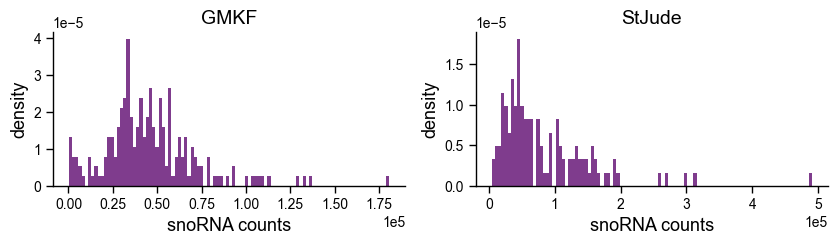

In [34]:
# filter down to any sno "genes" that have nonzero reads in any samples
fig, axes = plt.subplots(1, 2, figsize=(10, 2))

for i, d in enumerate([gmkf_counts, stjude_counts]):
    
    ax = axes[i]
    
    if i == 0:
        d = d.drop(columns = ['ENSEMBL_ID', 'gene_id']).set_index('gene_symbol')
    else:
        d = d.set_index('gene')
    
    sno_genes = [g for g in d.index if 'SNO' in g]
    ax.hist(d.loc[sno_genes].sum(axis=0), bins=100, density=True)
    ax.set_xlabel("snoRNA counts")
    ax.set_ylabel("density")
    sns.despine(ax=ax)
    ax.set_title(['GMKF', 'StJude'][i])
    # fig.savefig("images/cwas/tpms-snorna-counts.png", bbox_inches="tight")

Some of those values are definitely a little higher than I'd like, but it is what it is. I don't know enough to create some filter.

## PCA plot

In [35]:
rna_dict.keys()

dict_keys(['gmkf_neuroblastoma_normalized_counts', 'gmkf_neuroblastoma_tpms', 'gmkf_neuroblastoma_normalized_tpms', 'stjude_neuroblastoma_normalized_counts', 'stjude_neuroblastoma_tpms', 'stjude_neuroblastoma_normalized_tpms', 'stjude_ewing_normalized_counts', 'stjude_ewing_tpms', 'stjude_ewing_normalized_tpms'])

In [36]:
# normalize for PCA
pca_dfs = []
pca_models = []
for d_list in [['gmkf_neuroblastoma_tpms'], ['stjude_neuroblastoma_tpms', 'stjude_ewing_tpms'], ['gmkf_neuroblastoma_tpms', 'stjude_neuroblastoma_tpms', 'stjude_ewing_tpms']]:
    
    datasets = [rna_dict[d] for d in d_list]
    
    shared_genes = set(datasets[0].index)
    for d in datasets[1:]:
        shared_genes = shared_genes.intersection(d.index)
        
    datasets = [d.loc[shared_genes] for d in datasets]
    
    tpm_data = pd.concat(datasets, axis = 1)
    
    norm_matrix = preprocessing.StandardScaler().fit_transform(tpm_data.T)
    pca = decomposition.PCA(
        n_components=min(norm_matrix.shape[0] - 1, norm_matrix.shape[1]), random_state=0
    )

    # store the model
    pca_models.append(pca)

    # transform the data, then store the PC results
    pca_transformed_data = pca.fit_transform(norm_matrix)

    pca_tpm_df = pd.DataFrame(pca_transformed_data)
    pca_tpm_df.columns = ["PC" + str(i) for i in range(1, len(pca_tpm_df.columns) + 1)]
    pca_tpm_df.index = tpm_data.columns
    
    pca_tpm_df['cohort'] = ['gmkf' if s in gmkf_counts.columns else 'stjude' for s in pca_tpm_df.index]
    pca_tpm_df = pca_tpm_df[['cohort', 'PC1', 'PC2']]

    pca_dfs.append(pca_tpm_df)

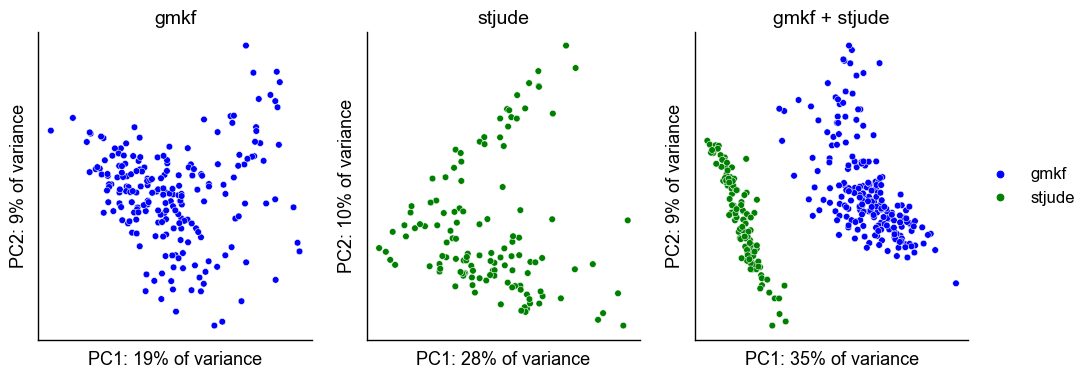

In [37]:
tpm_fig, tpm_axes = plt.subplots(1, 3, figsize=(12, 4))
for i, label in enumerate(["gmkf", "stjude", "gmkf + stjude"]):

    ax = tpm_axes[i]
    
    data = pca_dfs[i]
    pca_model = pca_models[i]

    # plot data
    sns.scatterplot(x="PC1", y="PC2", data = data, ax = ax, 
                    hue = 'cohort', palette = {'gmkf': 'blue', 'stjude': 'green'})

    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.tick_params(axis="both", which="both", length=0)

    ax.set_xlabel(
        "PC1: {:.0f}% of variance".format(
            pca_model.explained_variance_ratio_[0] * 100
        )
    )
    ax.set_ylabel(
        "PC2: {:.0f}% of variance".format(
            pca_model.explained_variance_ratio_[1] * 100
        )
    )
    ax.set_title(label)
    
    if i != 2:
        ax.legend().remove()
    else:
        ax.legend(bbox_to_anchor = (1, 0.5))

    sns.despine(ax = ax, bottom=False, left=False)

So we obviously cannot combine these data

## House keeping genes

Another metric we can use is the count of house-keeping genes.

In [41]:
# housekeeping = ["ACTB", "GAPDH", "TBP", "UBC", "RPS18"]
# housekeeping_counts = (
#     merged_counts[merged_counts["gene_symbol"].isin(housekeeping)]
#     .set_index("gene_symbol")
#     .iloc[:, 2:]
# )
# housekeeping_counts_norm = stats.zscore(housekeeping_counts, axis=1)

Let's plot these on a heatmap

In [42]:
# housekeeping_counts_norm

In [43]:
# # define a rough order
# sample_order = housekeeping_counts_norm.mean(axis=0).sort_values().index

# # make the figure and gridspec
# fig = plt.figure(figsize=(12, 3))
# gs = fig.add_gridspec(5, 2, width_ratios=[2, 1], wspace=0.12)

# # plot the heatmap
# heatmap_ax = fig.add_subplot(gs[:, 0])

# sns.heatmap(
#     housekeeping_counts_norm.loc[:, sample_order],
#     cmap="Blues",
#     robust=True,
#     ax=heatmap_ax,
#     cbar_kws={"orientation": "horizontal", "pad": 0.05, "shrink": 0.4},
# )
# heatmap_ax.set_yticklabels(housekeeping, rotation=0, ha="right", fontstyle="italic")
# heatmap_ax.tick_params(which="both", length=0)
# heatmap_ax.set_xticklabels([])
# heatmap_ax.set_ylabel("")
# heatmap_ax.set_xlabel("")

# gene_gs = matplotlib.gridspec.GridSpecFromSubplotSpec(
#     6, 1, gs[:, 1], height_ratios=[1] * 5 + [1.3]
# )
# for i, g in enumerate(housekeeping):
#     ax = fig.add_subplot(gene_gs[i])
#     ax.hist(housekeeping_counts_norm.loc[g, :], bins=100)
#     sns.despine(ax=ax, bottom=True)
#     ax.set_xlim([-2, 5])
#     if i != 4:
#         ax.get_xaxis().set_visible(False)

#     else:
#         ax.tick_params(axis="x", length=0)
#         ax.set_xlabel("expression z-score")

#     if i == 2:
#         ax.set_ylabel("sample count")

# fig.savefig("images/cwas/housekeeping-expression.png", bbox_inches="tight")

We can try arbitrarily removing a subset of samples if they exceed 2.5 stds of housekeeping expression in 3 housekeeping genes.

In [44]:
# percentiles = np.percentile(housekeeping_counts_norm, [95], axis=1).reshape(-1, 1)
# sample_filter = np.greater(housekeeping_counts_norm, percentiles)
# removed_samples = sample_filter.loc[:, sample_filter.sum(axis=0) >= 3]
# removed_samples

In [45]:
# removed_samples = removed_samples.columns

Out of curiosity, how does this look on a PCA plot?

In [46]:
# housekeeping_mean = housekeeping_counts_norm.mean(axis=0)

In [47]:
# tpm_fig, tpm_axes = plt.subplots(1, 2, figsize=(8, 4))

# norm = matplotlib.colors.Normalize(vmin=-1.5, vmax=2)
# for i, label in enumerate(["log_1p", "log_1p_protein"]):

#     data = pca_dict[label][["PC1", "PC2"]].copy()

#     # add in housekeeping data
#     data["housekeeping"] = housekeeping_mean.loc[data.index]

#     # plot data
#     points = tpm_axes[i].scatter(
#         data["PC1"],
#         data["PC2"],
#         c=data["housekeeping"],
#         cmap=plt.get_cmap("Blues"),
#         norm=norm,
#         edgecolor="black",
#         s=30,
#     )

#     removed = data.loc[removed_samples]
#     points = tpm_axes[i].scatter(
#         removed["PC1"], removed["PC2"], c="red", edgecolor=None, s=15
#     )

#     tpm_axes[i].set_xticklabels([])
#     tpm_axes[i].set_yticklabels([])
#     tpm_axes[i].tick_params(axis="both", which="both", length=0)

#     pca_results = pca_models[label]
#     tpm_axes[i].set_xlabel(
#         "PC1: {:.0f}% of variance".format(
#             pca_results.explained_variance_ratio_[0] * 100
#         )
#     )
#     tpm_axes[i].set_ylabel(
#         "PC2: {:.0f}% of variance".format(
#             pca_results.explained_variance_ratio_[1] * 100
#         )
#     )
#     tpm_axes[i].set_title(
#         ["log (TPM + 1)", "log (TPM + 1) (protein-coding only)", "log (TPM + 1) (hvg)"][
#             i
#         ]
#     )

#     sns.despine(bottom=False, left=False)

# tpm_fig.savefig("images/cwas/tpm-pca-matrix.png", bbox_inches="tight")

I mean... meh, right? Clearly these samples are slight outliers, but I see no reason to believe they're extremely abnormal. I don't see a frank need to remove them. So we keep all 89 samples.

## Adrenal signature

One important component of this analysis is that we have no idea of the underlying purity of these samples. This could be a pretty big problem, as eventually we'll be ranking these samples by expression. If a subset of samples have consistently low purity and these genes are relevant in an adrenal context, then we could get skewed results.

One way to check this is to devise an expression signature that is derived from adrenal-specific genes. This could (theoretically) help us control for these effects downstream. Maybe.

In [48]:
# adrenal_genes = pd.read_csv("ref/adrenal-specific-genes.txt", sep="\t", comment="#")[
#     "Gene Name"
# ].tolist()
# print(adrenal_genes)

In [49]:
# merged_tpms_pc_gsea = merged_tpms_protein_coding.set_index("gene_symbol").iloc[:, 2:]
# merged_tpms_pc_gsea.head(2)

In [50]:
# ss = gp.ssgsea(
#     data=merged_tpms_pc_gsea,
#     gene_sets={"adrenal": adrenal_genes},
#     outdir=None,
#     sample_norm_method="rank",
#     no_plot=True,
#     min_size=4,
# )

# adrenal_signature = ss.res2d
# adrenal_signature.columns = [
#     "sample",
#     "signature",
#     "enrichment_score",
#     "normalized_enrichment_score",
# ]

In [51]:
# fig, ax = plt.subplots(1, figsize=(5, 2))
# plt.hist(adrenal_signature["normalized_enrichment_score"], bins=30)
# ax.set_xlabel("Adrenal score")
# ax.set_ylabel("Sample count")
# sns.despine()
# fig.savefig("images/cwas/adrenal-specific-expression.png", bbox_inches="tight")

So there's definitely some variation there. This will be important to keep in mind.